In [1]:
import numpy as np

In [2]:
import modules.experiment.events as expevents
import modules.experiment.fov as expfov
import modules.eas_plane_fitting as easplane

from modules_reloader import reloader

relmod = reloader(expevents, easplane, expfov)

In [3]:
relmod()

In [4]:
processor = expevents.EventProcessor(N=45, verbosity=3, load_rir=False)
L = 10
N = processor.N

In [5]:
event_id = 10675
event = expevents.Event(event_id)
fov = expfov.PmtFov.for_event(event_id)

In [6]:
t_samples, channels = processor.read_reconstruction_marginal_sample_per_channel(event.id_, parameter='t')
t_samples = t_samples * 12.5  # bin -> ns

time_delays_ns = fov.delays(H=event.height)[channels]
t_samples -= time_delays_ns

t_samples -= t_samples.mean()

In [7]:
significances = processor.read_signal_significances(event.id_)[channels]

STRONG_SIGNIFICANCE = 6
weak_mask = np.logical_and(significances > 0, significances <= STRONG_SIGNIFICANCE)
strong_mask = significances > STRONG_SIGNIFICANCE

In [8]:
t_means = t_samples.mean(axis=0)[strong_mask]
t_stds = t_samples.std(axis=0)[strong_mask]
x_fov = fov.x[channels][strong_mask]
y_fov = fov.y[channels][strong_mask]

In [9]:
popt, perr, in_fit_mask = easplane.adaptive_excluding_fit(x_fov, y_fov, t_means, t_stds)

In [10]:
print(f'theta = {popt[0]} +/- {perr[0]}')
print(f'phi = {popt[1]} +/- {perr[1]}')

theta = 0.6391616163388432 +/- 0.03548389330839836
phi = 3.0279028475841896 +/- 0.0916321375270644


Text(0.5, 0, '$t$, нс')

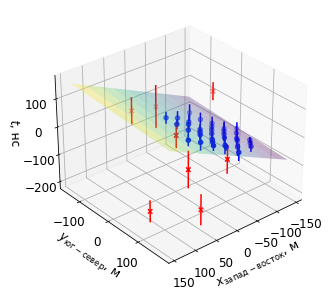

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from modules.plots._shared import Figsize, _save_or_show


n_grid = 10
extension_factor = 1.1
x_lims = np.array([x_fov.min(), x_fov.max()])
x_plane = np.linspace(*(x_lims.mean() + extension_factor * (x_lims - x_lims.mean())), n_grid)
y_lims = np.array([y_fov.min(), y_fov.max()])
y_plane = np.linspace(*(y_lims.mean() + extension_factor * (y_lims - y_lims.mean())), n_grid)
xx_plane, yy_plane = np.meshgrid(x_plane, y_plane)
z_plane = easplane.eas_plane(
    np.concatenate((xx_plane.reshape(xx_plane.size, 1), yy_plane.reshape(yy_plane.size, 1)), axis=1),
    *popt
).reshape(xx_plane.shape)


fig = plt.figure(figsize=Figsize.NORMAL.value)
ax = fig.add_subplot(111, projection='3d')

def plot_points_with_mask(mask, marker, color):
    ax.scatter(x_fov[mask], y_fov[mask], t_means[mask], marker=marker, color=color)
    for x, y, t_mu, t_sigma in zip(x_fov[mask], y_fov[mask], t_means[mask], t_stds[mask]):
        ax.plot([x, x], [y, y], [t_mu - t_sigma, t_mu + t_sigma], color=color)

plot_points_with_mask(in_fit_mask, 'o', 'b')
plot_points_with_mask(np.logical_not(in_fit_mask), 'x', 'r')

surf = ax.plot_surface(xx_plane, yy_plane, z_plane, cmap='viridis', alpha=0.3)
# surf = ax.plot_wireframe(xx_plane, yy_plane, z_plane, alpha=0.6)

# plt.savefig('test.png')

ax.view_init(azim=50, elev=30)
ax.set_xlabel('$x_{{\\mathrm{{запад-восток}}}}$, м')
ax.set_ylabel('$y_{{\\mathrm{{юг-север}}}}$, м')
ax.set_zlabel('$t$, нс')

# _save_or_show('eas-plane-fitting')